In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import torch.nn as nn
from tqdm import tqdm
import utils
import pickle
import lightgbm as lgb
import random
import optuna
from transformers import AlbertTokenizer, AlbertModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 100
max_length = 44
MAX_TWEETS= 650
PAD_TWEET = "[PAD]" 

/users/eleves-a/2022/amine.chraibi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/amine.chraibi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2022/amine.chraibi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preparing dataset


In [14]:
# count number of characters 
def count_chars(text):
    return len(text)

# count number of words 
def count_words(text):
    return len(text.split())

# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

# count number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

# count number of punctuations
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d

# count number of words in quotes
def count_words_in_quotes(text):
    x = re.findall("\'.\'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
# count number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

# calculate average word length
def avg_word_len(char_cnt,word_cnt):
    return char_cnt/word_cnt

# calculate average sentence length
def avg_sent_len(word_cnt,sent_cnt):
    return word_cnt/sent_cnt

# count number of unique words 
def count_unique_words(text):
    return len(set(text.split()))
            
# words vs unique feature
def words_vs_unique(words,unique):
    return unique/words

# count of hashtags
def count_htags(text):
    x = re.findall(r'(\#\w[A-Za-z0-9]*)', text)
    return len(x)

# count of mentions
def count_mentions(text):
    x = re.findall(r'(\@\w[A-Za-z0-9]*)', text)
    return len(x)

stop_words = set(stopwords.words('english'))  

# count of stopwords
def count_stopwords(text):
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

# stopwords vs words
def stopwords_vs_words(stopwords_cnt,text):
    return stopwords_cnt/len(word_tokenize(text))

In [31]:
import pickle

with open('data_test.pkl', 'rb') as file:
    test = pickle.load(file)

with open('data_train.pkl', 'rb') as file:
    train = pickle.load(file)


In [3]:
import os
import pickle
import torch

def prepare_features_and_labels(grouped_tweets, grouped_labels, bert_model, tokenizer, output_file="features_labels.pkl"):
    """
The function `prepare_features_and_labels` is preparing features and labels using BERT embeddings and saving them to a file. 
It takes as input parameters a DataFrame `grouped_tweets` with columns MatchID, PeriodID, and OriginalTweets, 
another DataFrame `grouped_labels` with labels (EventType) by MatchID and PeriodID, a pre-trained BERT model `bert_model`,
a BERT tokenizer `tokenizer`, and an optional output file name `output_file` (default is "features_labels.pkl").
    """
    if os.path.exists(output_file):
        print(f"Chargement des features et labels depuis {output_file}...")
        with open(output_file, "rb") as f:
            data = pickle.load(f)
        return data["grouped_tweets"], data["labels"]

    labels = []
    embeddings = []

    print("Calcul des embeddings et labels...")
    for idx, row in tqdm(grouped_tweets.iterrows()):
        tweets = row['Tweet']
        if not isinstance(tweets, list) or len(tweets) == 0:
            embeddings.append(torch.zeros(bert_model.config.hidden_size))  
            continue

        tokenized = tokenizer(
            tweets,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        with torch.no_grad():
            embed = bert_model.embeddings.word_embeddings(tokenized['input_ids'])
        
        features_mean = embed.mean(dim=1).mean(dim=0)  # Average across tokens, then across tweets
        embeddings.append(features_mean)

        match_id, period_id = row['MatchID'], row['PeriodID']
        labels.append(grouped_labels.loc[match_id, period_id])

    grouped_tweets['Embedding'] = embeddings

    print(f"Sauvegarde des features et labels dans {output_file}...")
    grouped_tweets = grouped_tweets.drop(columns=['Tweet'])
    with open(output_file, "wb") as f:
        pickle.dump({"grouped_tweets": grouped_tweets, "labels": labels}, f)
    return grouped_tweets, labels

In [10]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

features, labels = prepare_features_and_labels(
    grouped_tweets=agg_df,
    grouped_labels=grouped_labels_df,
    bert_model=bert_model,
    tokenizer=tokenizer,
    output_file="features_labels_lgbm_spacy_new_features.pkl"
)

KeyboardInterrupt: 

In [4]:
vectorizer            =  TfidfVectorizer()
train_tf_idf_features =  vectorizer.fit_transform(train['Tweet'])
test_tf_idf_features  =  vectorizer.transform(test['Tweet'])
train_tf_idf          = pd.DataFrame(train_tf_idf_features)
test_tf_idf           = pd.DataFrame(test_tf_idf_features)

In [32]:
train = pd.concat([train.reset_index(drop=True), train_tf_idf.reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), test_tf_idf.reset_index(drop=True)], axis=1)

In [36]:
train = train.drop(columns=['Timestamp'])
test = test.drop(columns=['Timestamp'])
train['TweetCount'] = train.groupby(group_cols)['Tweet'].transform('count')
test['TweetCount'] = test.groupby(group_cols)['Tweet'].transform('count')

In [34]:
train.head()

,ID,MatchID,PeriodID,EventType,Tweet,char_count,word_count,sent_count,capital_char_count,capital_word_count,...,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,0
0,10_2,10,2,0,rt worldcupposts argentina beat germany today ...,140,24,2,19,3,...,0,0,0,1,0,0,0,0,0,"(0, 694189)\t0.13407019765550307\n (0, 8209..."
1,5_7,5,7,1,rt marialfc_ come germany ger,36,6,2,22,5,...,0,0,0,0,0,0,0,0,0,"(0, 694189)\t0.10598687893223953\n (0, 2089..."
2,10_46,10,46,0,watching germany v argentina,30,4,1,2,0,...,0,0,0,0,0,0,0,0,0,"(0, 45208)\t0.5045961582463401\n (0, 208910..."
3,1_63,1,63,0,adidasfussball wir sind allin nothing brager w...,87,9,1,20,3,...,0,0,0,0,0,0,0,0,0,"(0, 16697)\t0.42959685511103585\n (0, 81736..."
4,13_5,13,5,1,rt worldsoccershop nga beat fra today well giv...,133,21,3,19,4,...,0,0,0,0,0,0,0,0,0,"(0, 694189)\t0.15983427944771075\n (0, 6547..."


In [8]:
## For efficient memory management
## This cell looks like it doesn't work as it prints an error but it has the intended effect (you can check stacked_df.info() before
# and after this cell, we didn't include it so as not to flood the notebook.)
def optimize_dataframe(df):
    """
    Optimize the data types of a DataFrame to reduce memory usage.
    """
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'int64':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='signed')
        
        elif col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        
        elif col_type == 'object':
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')
    
    return df

# Optimize both train and test DataFrames
train = optimize_dataframe(train)
test = optimize_dataframe(test)


TypeError: unhashable type: 'csr_matrix'

In [38]:
group_cols = ['MatchID', 'PeriodID']
agg_dict = {
    col: 'first' if col == 'EventType' else 'count'
    for col in train.columns
    if col not in group_cols
}

agg_dict['Tweet'] = lambda x: list(x)
agg_dict['TweetCount'] = 'first'
agg_train = train.groupby(group_cols).agg(agg_dict).reset_index()


agg_test = test.groupby(group_cols).agg(agg_dict).reset_index()

grouped_labels_train = train.groupby(['MatchID', 'PeriodID'])['EventType'].max().unstack(fill_value=0)
grouped_labels_test = test.groupby(['MatchID', 'PeriodID'])['EventType'].max().unstack(fill_value=0)


In [40]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

features_train, labels_train = prepare_features_and_labels(
    grouped_tweets=agg_train,
    grouped_labels=grouped_labels_train,
    bert_model=bert_model,
    tokenizer=tokenizer,
    output_file="features_labels_lgbm_spacy_new_features_train.pkl"
)

features_test, labels_test = prepare_features_and_labels(
    grouped_tweets=agg_test,
    grouped_labels=grouped_labels_test,
    bert_model=bert_model,
    tokenizer=tokenizer,
    output_file="features_labels_lgbm_spacy_new_features_test.pkl"
)

Calcul des embeddings et labels...


1344it [12:07,  1.85it/s]


Sauvegarde des features et labels dans features_labels_lgbm_spacy_new_features_train.pkl...
Calcul des embeddings et labels...


285it [00:46,  6.16it/s]

Sauvegarde des features et labels dans features_labels_lgbm_spacy_new_features_test.pkl...


In [51]:
features_test.head()

,MatchID,PeriodID,ID,EventType,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,...,^ count,_ count,` count,{ count,| count,} count,~ count,0,TweetCount,Embedding
0,10,0,736,0,736,736,736,736,736,736,...,736,736,736,736,736,736,736,736,736,"[tensor(-0.0170), tensor(-0.0501), tensor(-0.0..."
1,10,1,764,0,764,764,764,764,764,764,...,764,764,764,764,764,764,764,764,764,"[tensor(-0.0162), tensor(-0.0507), tensor(-0.0..."
2,10,2,769,0,769,769,769,769,769,769,...,769,769,769,769,769,769,769,769,769,"[tensor(-0.0154), tensor(-0.0507), tensor(-0.0..."
3,10,3,832,0,832,832,832,832,832,832,...,832,832,832,832,832,832,832,832,832,"[tensor(-0.0157), tensor(-0.0506), tensor(-0.0..."
4,10,4,761,0,761,761,761,761,761,761,...,761,761,761,761,761,761,761,761,761,"[tensor(-0.0155), tensor(-0.0511), tensor(-0.0..."


In [57]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import joblib


def convert_embedding(embedding_tensor):
    return embedding_tensor.detach().cpu().numpy()

embedding_train = np.vstack(features_train['Embedding'].apply(convert_embedding).values)

embedding_test = np.vstack(features_test['Embedding'].apply(convert_embedding).values)

group_cols = ['MatchID', 'PeriodID']

# We remove 'Embedding' here because we add it later
columns_to_drop = ['EventType', 'MatchID', 'PeriodID', 'Embedding']

X_features_train = features_train.drop(columns=columns_to_drop)
X_features_train = X_features_train.values  
X_features_test = features_test.drop(columns=columns_to_drop)
X_features_test = X_features_test.values  


X_train = np.hstack([X_features_train, embedding_train])

X_test = np.hstack([X_features_test, embedding_test])


y_train = features_train['EventType'].values

if 'EventType' in features_test.columns:
    y_test = features_test['EventType'].values
else:
    y_test = None  


params = {
    'learning_rate': 0.020559564255188685,
    'num_leaves': 175,
    'max_depth': 38,
    'min_data_in_leaf': 24,
    'feature_fraction': 0.8206274379058552,
    'bagging_fraction': 0.5008300119237329,
    'bagging_freq': 9,
    'lambda_l1': 3.0495576636476773,
    'lambda_l2': 0.05257346531813992,
    'min_gain_to_split': 0.26065506527165566,
    'n_estimators': 759,
    'verbose': -1
}

model = lgb.LGBMClassifier(**params)

print("Training the LightGBM model...")
model.fit(X_train, y_train)


print("Making predictions on the test set...")
y_pred = model.predict(X_test)


if y_test is not None:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
else:
    print("y_test is not available. Skipping accuracy calculation.")

# Save the trained model for future use
model_filename = 'lightgbm_model.pkl'
joblib.dump(model, model_filename)
print(f"Trained model saved as {model_filename}.")


Training the LightGBM model...
Making predictions on the test set...
Test Accuracy: 0.8175

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       163
           1       0.81      0.75      0.78       122

    accuracy                           0.82       285
   macro avg       0.82      0.81      0.81       285
weighted avg       0.82      0.82      0.82       285

Trained model saved as lightgbm_model.pkl.


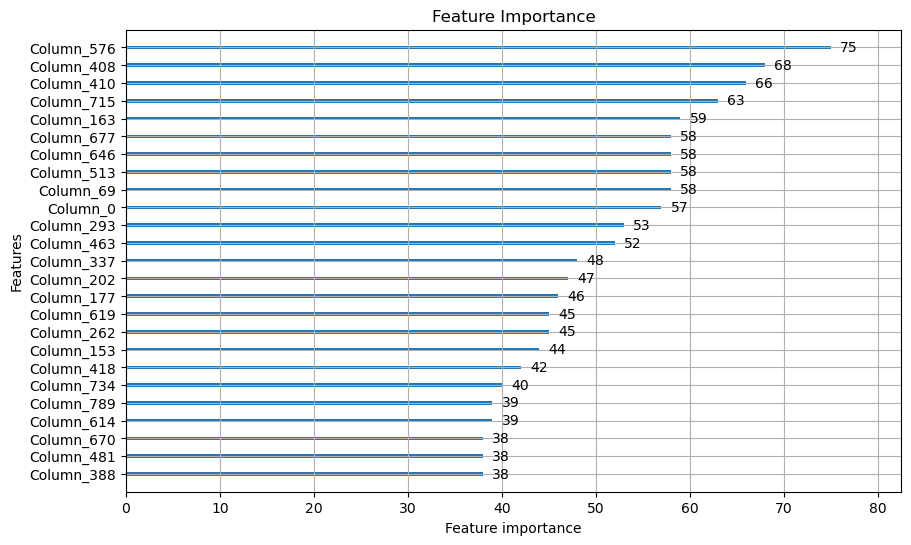

In [64]:
# Plot feature importance
lgb.plot_importance(model, importance_type='split', max_num_features=25, figsize=(10, 6))

plt.title('Feature Importance')
plt.show()

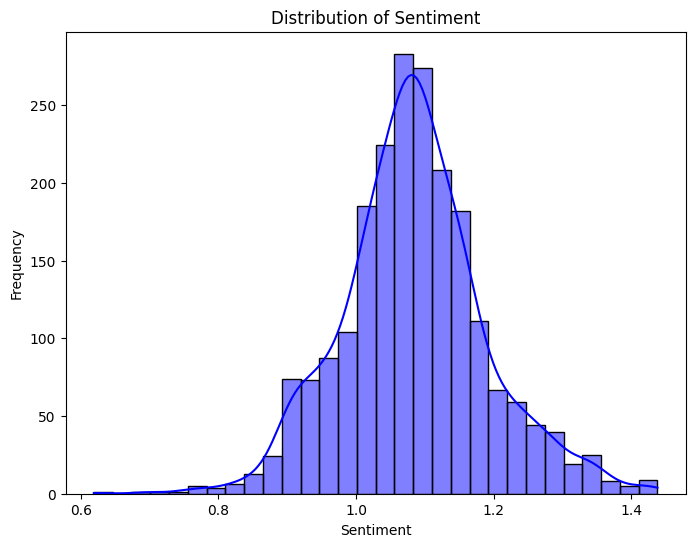

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the 'Sentiment' column (continuous variable)
plt.figure(figsize=(8, 6))
sns.histplot(features['Sentiment'], bins=30, kde=True, color='blue') 
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()
